<b>Download link:</b>  https://www.kaggle.com/alxmamaev/flowers-recognition/home

<b>Summary:</b> Classifier built using resnet pretrained model


In [4]:
import torch
from torchvision import datasets, models, transforms 
import os
from shutil import copyfile, move
import numpy as np
import matplotlib.pyplot as plt
import torchvision

#### Preparing transformations for datanormalization

In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [7]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

#### Unzip images

In [17]:
import zipfile
zip = zipfile.ZipFile('datasets/flowers-recognition.zip')
zip.extractall('datasets')

In [8]:
data_dir = "datasets/flowers"
image_datasets= dict()

#### This step is no longer necessary for the way the dataset is loaded further

In [19]:
# separate images in 2 dirs
if not os.path.isdir(os.path.join(data_dir, 'train')):
    os.mkdir(os.path.join(data_dir, 'train'))
if not os.path.isdir(os.path.join(data_dir, 'test')):
    os.mkdir(os.path.join(data_dir, 'test'))
flower_labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']



In [20]:
## Copy images from all the folders into the train folder
data_set_list = []
for item in  flower_labels:
    i = 0
    for image in os.listdir(os.path.join(data_dir, item)):
        copyfile(os.path.join(data_dir,item, image), os.path.join(data_dir, 'train', item + '_' + str(i) + '.jpg'))
        data_set_list.append(item + '_' + str(i) + '.jpg')
        i += 1

In [46]:
## Move from train folder a certain split into test
test_split = 0.2
it = int(len(data_set_list) / (len(data_set_list) * test_split))
dataset_list_test = []
for i in range(len(data_set_list)):
    if i % 5 == 0:
        move(os.path.join(data_dir, 'train', data_set_list[i]), os.path.join(data_dir, 'test', data_set_list[i]))
        dataset_list_test.append(data_set_list[i])

In [48]:
image_datasets['train']= datasets.ImageFolder(data_dir + '/train_/', train_transform)
print('Trin dataset size : ' + str(len(image_datasets['train'])))
class_names = image_datasets['train'].classes
print('Classes '  +str(class_names))
train_dataloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size = 8, shuffle = True, num_workers = 2)

Trin dataset size : 4323
Classes ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


#### Examine a batch

In [16]:
inputs, labels = next(iter(train_dataloader))
print(labels)
inputs, labels = iter(train_dataloader).next()
print(labels)

tensor([4, 4, 3, 1, 0, 2, 3, 4])
tensor([2, 4, 1, 0, 1, 4, 1, 2])


In [17]:
plt.ion()
def img_show(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(16,4))
    plt.axis('off')
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)

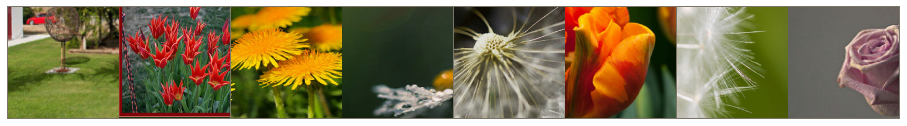

In [18]:
inp = torchvision.utils.make_grid(inputs)
img_show(inp)

### Load ResNet pretrained model

In [19]:
model = models.resnet18(pretrained = True)
num_features = model.fc.in_features
num_features

512

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

In [21]:
use_cuda = False
if torch.cuda.is_available():
    use_cuda = True

In [28]:
model.fc = nn.Linear(num_features, len(image_datasets['train'].classes))

### Define the training setp
This training method will pe called for each epoch
* <b>scheduler.step()</b> will set up the scheduler for each step in order to decay the learning rate
* <b>model.train()</b> will set the pre-trained model into training mode. This is only available for pre-trained models
* <b>running_loss</b> will keep track of the loss at each iteration
* <b>running_corrects</b> keeps a count of the number of correct predictions which will be used to calculate the accuracy of the model
<br />
* By setting <b>torch.set_grad_enabled(True)</b> we are enabling Autograd
* <b>outputs</b> is the list probabilities for each possible label for the batch of images (which are the inputs). We use torch.max() to get the index of the highest probability label for each image in the batch

In [45]:
def calculate_accuracy(running_loss, running_corrects):
    epoch_loss = running_loss/ len(train_dataloader)
    epoch_acc = float(running_corrects) / (len(train_dataloader) * 8)
    print('Correct pred {} / len dataset {} '. format(running_corrects, len(train_dataloader)*8))
    print('Loss: {:.4f} Acc: {:.4f}'.format( epoch_loss, epoch_acc))
    return (epoch_loss, epoch_acc)

In [23]:
def train_model(model, criterion, optimizer, scheduler, use_cuda):
    scheduler.step()
    model.train()
    running_loss = 0.0
    running_corrects = 0
    batch_num = 0
    
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
#         print("Batch {}/{}".format(batch_num, len(train_dataloader)))
#         batch_num+=1
        
        if use_cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item() 
    calculate_accuracy(running_loss, running_corrects)

In [24]:

def test_model(model, criterion, optimizer, use_cuda):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    best_accuracy = 0
    
    batch_num = 0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
#         print("Batch {}/{}".format(batch_num, len(train_dataloader)))
#         batch_num += 1
        
        if use_cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        
    epoch_loss, epoch_acc = calculate_accuracy(running_loss, running_corrects)
    
    if epoch_acc > best_accuracy:
        best_accuracy = epoch_acc
        best_model_weights = copy.deepcopy(model.state_dict())
        
    return best_model_weights, best_accuracy

### Build model

In [29]:
def build_model(model, criterion, optimizer, scheduler, num_epochs= 10, use_cuda = False):
    
    best_model_weights = copy.deepcopy(model.state_dict())
    if use_cuda:
        model.cuda()
        
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10 + '\n')
        
        train_model(model, criterion, optimizer, scheduler, use_cuda)
        best_model_weights, best_accuracy = test_model(model, criterion, optimizer, use_cuda)
        
    print('Best test acc {}'.format(best_accuracy))
    
    model.load_state_dict(best_model_weights)
    return model

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

model = build_model (model, criterion, optimizer, exp_lr_scheduler, num_epochs = 1, use_cuda = use_cuda)

Epoch 0/1
----------

Correct pred 3612 / len dataset 4328 
Loss: 3.8027 Acc: 0.8346
Correct pred 3816 / len dataset 4328 
Loss: 2.4066 Acc: 0.8817
Best test acc 0.8817005545286506


#### Checking performance

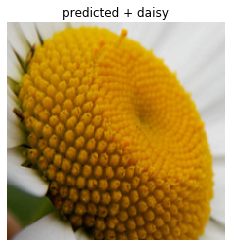

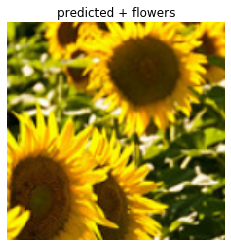

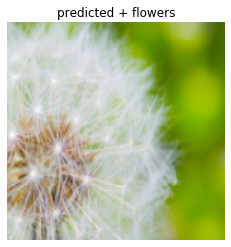

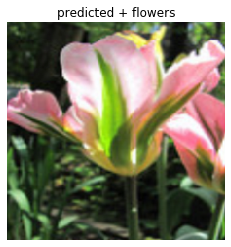

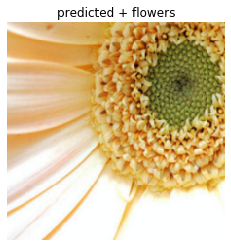

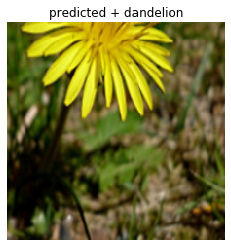

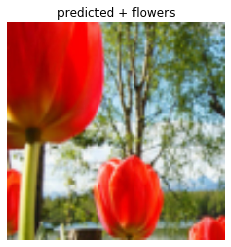

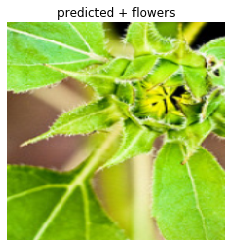

In [65]:
with torch.no_grad():
    inputs, labels = iter(train_dataloader).next()
    grid = torchvision.utils.make_grid(inputs)
    
    if use_cuda:
        inputs = inputs.cuda()
        
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        grid = inputs.data[j]
        grid = grid.cpu()
        img_show(grid, 'predicted  '  + class_names[preds[j]])

### Freezing layers

In [25]:
frozen_model = models.resnet18(pretrained=True)

for param in frozen_model.parameters():
    param.requires_grad = False

In [26]:
frozen_model.fc = nn.Linear(num_features, len(class_names))

In [31]:
optimizer = optim.SGD(frozen_model.fc.parameters(), # very important
                     lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size =7, gamma = 0.1)
criterion = nn.CrossEntropyLoss()


In [32]:
frozen_model = build_model(frozen_model, criterion, optimizer, exp_lr_scheduler, num_epochs=1, use_cuda= use_cuda)

Epoch 0/1
----------

train Loss: 6.1731 Acc: 5.7061
train Loss: 3.5916 Acc: 6.6599
Best test acc 6.659889094269871


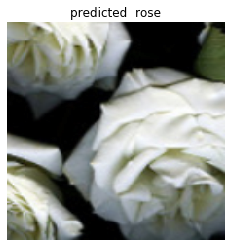

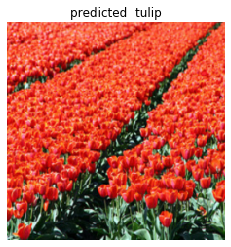

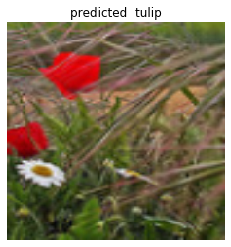

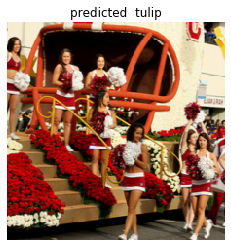

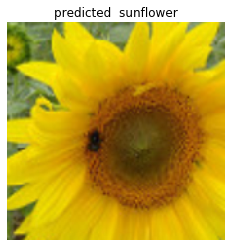

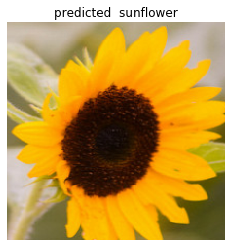

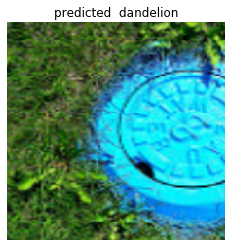

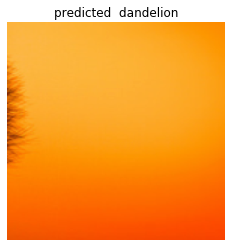

In [39]:
with torch.no_grad():
    inputs, labels = iter(train_dataloader).next()
    
    if use_cuda:
        inputs = inputs.cuda()
        
    outputs = frozen_model(inputs)
    _, preds = torch.max(outputs,1)
    
    for j in range(len(inputs)):
        img = inputs.data[j]
        img = img.cpu()
        img_show(img, 'predicted  '  + class_names[preds[j]])